In [ ]:
#Training pre-trained models 

#Dataset original image size : 256 x 256 pixels
#Resize to 128x128 

In [1]:
#Load libraries

#Data management, analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import os
import random

#Train-test split
from sklearn.model_selection import train_test_split # split data into train and test sets

#Image manipulation
from skimage.io import imread_collection
import skimage.io
import skimage.color
import skimage.transform
from PIL import Image

#Importing the Keras libraries and packages
#Importing the Keras libraries and packages
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop





**Loading and Pre-processing Data**

In [ ]:
#If not using google colab, please skip to the cell 'Extract filenames..'

In [2]:
#If using google colab and accessing kaggle dataset
#To get dataset from kaggle to use in google colab, refer to this blog, https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

#from google.colab import files
#files.upload() #upload kaggle.json


In [3]:
#Setting up and installing kaggle library

#!pip install --upgrade --force-reinstall --no-deps kaggle
#!mkdir -p ~/.kaggle
#!cp kaggle.json ~/.kaggle/
#!chmod 600 ~/.kaggle/kaggle.json

In [4]:
#Download the dataset from kaggle
#https://www.kaggle.com/jhoward/rsna-hemorrhage-jpg

#! kaggle datasets download jhoward/rsna-hemorrhage-jpg

In [5]:
#Extract the files 

#!unzip rsna-hemorrhage-jpg.zip

In [2]:
#Extract filenames from the folder of images

filenames = []
for root, dirs, files in os.walk('archive/train_jpg/train_jpg'):
    for file in files:
        if file.endswith('.jpg'):
            filenames.append(file)

In [3]:
len(filenames)

194082

In [4]:
#Load the labels file
labels = pd.read_feather('archive/meta/meta/labels.fth')



In [5]:
#Go through filename list to remove the .jpg at the end
idstosearch = [item.rstrip(".jpg") for item in filenames]

#Search the "ID" column for IDs that correspond to the filenames
labels = labels[labels['ID'].isin(idstosearch)]

In [6]:
#Obtain dataset with only images with 3+ hemorrhages types and healthy images that are randomized

random.seed(10)
images_hem = labels[labels[['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']].sum(1) >= 3].copy()
images_healthy = labels[labels['any'] == 0].copy()
images_healthy = images_healthy.sample(n = 20000)
frames = [images_healthy, images_hem]
images_data = pd.concat(frames)
images_data = images_data.sort_values('ID')
print("Number of images with hemorrhage: "+"{}".format(len(images_hem)))
print("Number of healthy images: "+"{}".format(len(images_healthy)))
print("Percent of dataset with 3+ hemorrhage types: "+"{:.2%}".format(len(images_hem)/len(images_data)))

Number of images with hemorrhage: 6547
Number of healthy images: 20000
Percent of dataset with 3+ hemorrhage types: 24.66%


In [7]:
#function to resize image files and add to numpy array

def convert_img(path):
    #path - path to the image file
    #returns image as numpy array
    img = image.load_img(path, target_size = (128,128))
    img = image.img_to_array(img)
    return img

In [8]:
#Import images from the dataset

imagelist = images_data['ID']
imageids = ["archive/train_jpg/train_jpg/"+ x + ".jpg" for x in imagelist]
images = imread_collection(imageids)



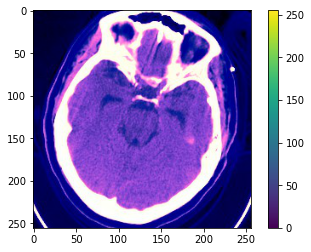

In [13]:
# Plot the first image
plt.figure()
plt.imshow(images[0])
plt.colorbar()
plt.grid(False)
plt.show()

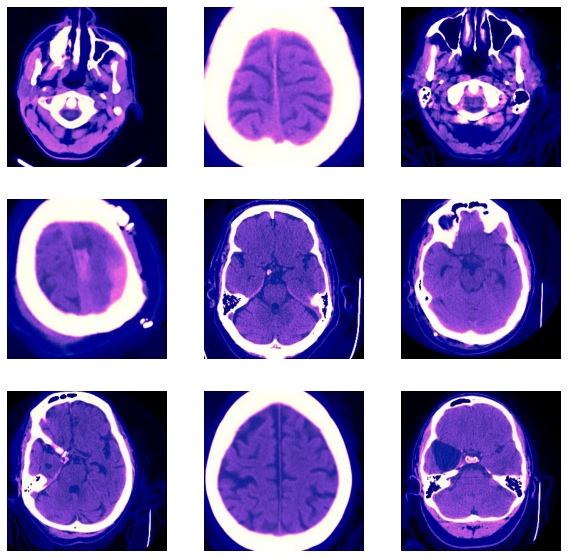

In [9]:
#Visualize the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.axis("off")

In [10]:
#Convert train and test images into numpy arrays and resize the images

images_arr =np.array([convert_img(img)
                    for img in imageids])


images_arr.shape

(26547, 128, 128, 3)

In [11]:
labels = images_data.iloc[:, 1]

In [12]:
#Convert labels to numpy array
labels = pd.Series.to_numpy(labels)
print(labels.shape)

(26547,)


In [13]:
#Splitting dataset into train, validation and test sets at 80%, 10% and 10% respectively.

#Split data into train and remaining dataset
train, X_re, labels_train, y_re = train_test_split(images_arr, labels, train_size=0.80,stratify=labels,random_state=1)

#Split remaining data into test and validation with 50% split 
val, test, labels_val, labels_test = train_test_split(X_re, y_re, test_size=0.5, stratify=y_re,random_state=1)

In [14]:
print(train.shape)
print(test.shape)
print(val.shape)
print(labels_train.shape)
print(labels_test.shape)
print(labels_val.shape)


(21237, 128, 128, 3)
(2655, 128, 128, 3)
(2655, 128, 128, 3)
(21237,)
(2655,)
(2655,)


In [15]:
#Normalize the images by dividing each pixel by 255



train_datagen = ImageDataGenerator(rescale = 1./255,
                                    )
val_datagen = ImageDataGenerator(rescale = 1./255,
                                    )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                    )


In [16]:
#Import the pre-trained models
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg19 import VGG19
#from keras.applications.resnet import ResNet50

In [17]:
 # Build model

model = InceptionResNetV2(include_top=False, input_shape=(128,128,3),weights='imagenet')
#Make model not trainable for use in feature extraction
for layer in model.layers:
  layer.trainable = False
#Get last layer
last_output = model.layers[-1].output

# Flatten the output layer to 1 dimension
res = Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
res = Dense(1024, activation='relu')(res)
# Add a dropout rate of 0.2
res = Dropout(0.2)(res)
# Add a final sigmoid layer for classification
res = Dense(1, activation='sigmoid')(res)

# Configure and compile the model
model = Model(model.input, res)
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.0001),
              metrics=['acc'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 63, 63, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 63, 63, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [19]:
train_generator = train_datagen.flow(train, labels_train, batch_size=32)

validation_generator = val_datagen.flow(val, labels_val, batch_size= 32)

In [20]:
history = model.fit(train_generator, epochs = 10,  validation_data= (validation_generator), verbose = 1)

Epoch 1/10
664/664 [==============================] - 602s 898ms/step - loss: 0.3640 - acc: 0.8730 - val_loss: 0.2777 - val_acc: 0.9047
Epoch 2/10
664/664 [==============================] - 694s 1s/step - loss: 0.2393 - acc: 0.9081 - val_loss: 0.2108 - val_acc: 0.9239
Epoch 3/10
664/664 [==============================] - 814s 1s/step - loss: 0.2122 - acc: 0.9216 - val_loss: 0.2418 - val_acc: 0.9194
Epoch 4/10
664/664 [==============================] - 824s 1s/step - loss: 0.1942 - acc: 0.9285 - val_loss: 0.2431 - val_acc: 0.9183
Epoch 5/10
664/664 [==============================] - 873s 1s/step - loss: 0.1728 - acc: 0.9346 - val_loss: 0.1904 - val_acc: 0.9311
Epoch 6/10
664/664 [==============================] - 928s 1s/step - loss: 0.1627 - acc: 0.9401 - val_loss: 0.2023 - val_acc: 0.9337
Epoch 7/10
664/664 [==============================] - 693s 1s/step - loss: 0.1524 - acc: 0.9447 - val_loss: 0.2098 - val_acc: 0.9258
Epoch 8/10
664/664 [==============================] - 786s 1s/step

In [21]:
model.save('inceptionres_modelb.h5')

Text(0.5, 1.0, 'Training and validation loss')

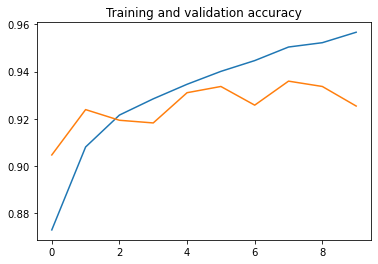

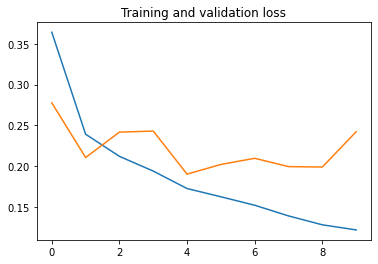

In [22]:


# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [23]:
#Evaluate metrics
 
train_acc =model.evaluate(train_generator, verbose=1)
val_acc = model.evaluate(validation_generator, verbose=1)

83/83 [==============================] - 57s 690ms/step - loss: 0.2423 - acc: 0.9254


In [24]:
#Test the model

test_generator = test_datagen.flow(test, labels_test, batch_size= 32)
predictions = model.predict(test_generator)

test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print("Test Accuracy: "+"{:.2%}".format(test_acc))

83/83 [==============================] - 50s 603ms/step - loss: 0.2333 - acc: 0.9202
Test Accuracy: 92.02%
